[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/GaoyuanWu/JaxSSO/blob/main/Examples/Arch_2D.ipynb)

In [14]:
!pip install JaxSSO
!pip install PyNiteFEA
!pip install nlopt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import matplotlib.pyplot as plt
import numpy as np
import PyNite as pyn #FEA solver
import JaxSSO as sso #Sensitivity analysis solver

# Define the objective function and the gradient of the objective

*   The geometry, mesh
*   Build the FEA model
*   Build the SSO model


Setup: the nodes, connectivity, the load, the element's properties

In [32]:
#Nodes
n_node = 21
x_span = 10
x_nodes = np.linspace(0,x_span,n_node)
y_nodes = np.zeros(n_node)
z_nodes = np.random.uniform(0,0.5,n_node)
z_nodes[0] = 0
z_nodes[n_node-1] = 0
design_nodes = np.array([i for i in range(n_node) if i!=0 and i!=n_node-1])
non_design_nodes = np.array([i for i in range(n_node) if i==0 or i==n_node-1])
#Connectivity
n_ele = n_node -1 #number of elements
cnct = np.zeros((n_ele,2),dtype=int) #connectivity matrix
x_ele = np.zeros((n_ele,2))
y_ele = np.zeros((n_ele,2))
z_ele = np.zeros((n_ele,2))
for i in range(n_ele):
  cnct[i,0] = i
  cnct[i,1] = i+1
  x_ele[i,:] = [x_nodes[i],x_nodes[i+1]]
  y_ele[i,:] = [y_nodes[i],y_nodes[i+1]]
  z_ele[i,:] = [z_nodes[i],z_nodes[i+1]]

#Sectional properties-> 600x400 rectangle
h = 0.6 #height
b = 0.4 #width
E = 37900 * 10**6 #Young's modulus (pa)
G = E/(2*(1+0.3)) #Shear modolus-> E = 2G(1+mu)
Iy = b*h**3/12 #Moement of inertia in m^4
Iz = h*b**3/12 #Same, about z axis
J = Iy + Iz	#Polar moment of inertia
A = b*h #Area

#Nodal loads
load = -10000 #Newton
f = np.zeros(n_node*6)
f[design_nodes*6+2] = load # nodal load in -z

Draw the initial geometry

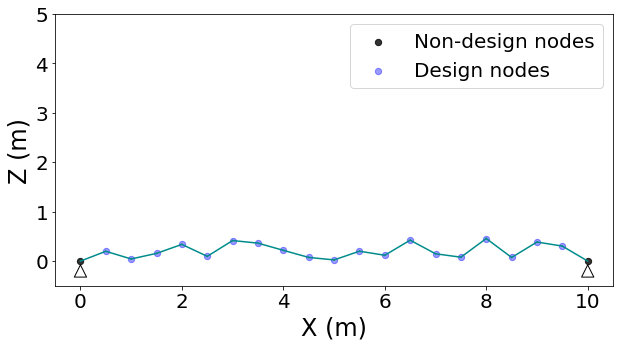

In [33]:
%matplotlib inline
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()

Inital FEA model

In [34]:
#Build the model
model = pyn.FEModel3D() #model for FEA solving


#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):

  #Adding nodes
  model.add_node("{}".format(i),x_nodes[i],y_nodes[i],z_nodes[i])

  if i in design_nodes:
    model.add_node_load('{}'.format(i),'FZ',load,case='Case 1')
  else:
    model.def_support('{}'.format(i), True, True, True, True, False, True) 

#Adding members
for i in range(n_ele):
  i_node = "{}".format(cnct[i,0]) #i-node of beam
  j_node = "{}".format(cnct[i,1]) #j-node of beam
  model.add_member("{}".format(i),i_node,j_node,E,G,Iy,Iz,J,A)



#Add load combo
model.add_load_combo('DEAD',{'Case 1':1})

Initial SSO model

In [35]:
#Build the model
sens_model = sso.Model_Sens.Model_Sens() #model for sensitivity analysis

#Adding nodes and point loads at free nodes
#set b.c. to the fixed nodes
for i in range(n_node):
  #Adding nodes
  sens_model.node(i,x_nodes[i],y_nodes[i],z_nodes[i])

#Adding elements
for i in range(n_ele):
  i_node = cnct[i,0]
  j_node = cnct[i,1]
  sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A)

Define the objective function (with its gradient).

Create some lists/arrays to store the intermediate results.

In [36]:
params_store = [] #store parameters
f_store = [] #store the functional value 

In [37]:
def objective(x):
  params_store.append(x) #store params at each step

  #################
  #Function value#
  #################

  #Update nodes-z
  for i in range(design_nodes.shape[0]):
    model.Nodes[str(design_nodes[i])].Z = x[i] #update params in FEA model
    sens_model.nodes[design_nodes[i]].Z = x[i] #update params in SSO model
  
  #Update elements
  #In FEA model, the element is updated automatically,
  #here we only update SSO model
  for i in range(n_ele):
    i_node = cnct[i,0]
    j_node = cnct[i,1]
    sens_model.beamcol(i,i_node,j_node,E,G,Iy,Iz,J,A) #update elements

  #FEA: solve [K]{u}={f}
  #Get {u}, displacement vector; C=0.5*{f}.T@{u}, compliance(strain energy)
  model.analyze(check_statics=False)
  u = model._D['DEAD'].reshape(-1) #displacement in 1-D vector
  C = 0.5*f@u #compliance of the system
  f_store.append(C) #store the compliance 

  ##################
  #  Gradient  #
  ##################
  #Get the sensitivity using SSO
  sens = sens_model.Sens_C_Coord(u)
  z_dof_index = design_nodes*3+2 #index indicating the z-dof
  sens_params = sens[z_dof_index] #storing the sensitivity of obj. wrt design parameters
  return C,sens_params

# Perform the optimization

In [38]:
n_x = design_nodes.shape[0] #number of parameters
x_ini = z_nodes[design_nodes] #initial parameters 
opt = sso.Optimization.Optimization(n_x,method='GD')
opt.set_objective(objective) #objective function
opt.set_maxiter(150) #max iteration
opt.set_step_size(5e-2) #step size
x_opt = opt.optimize(x_ini,log=True)

Step 0, objective = 351.57870980547773
Step 1, objective = 412.38834231856316
Step 2, objective = 100.75511004242834
Step 3, objective = 26.282550849312486
Step 4, objective = 16.889981968442704
Step 5, objective = 12.165786644569359
Step 6, objective = 9.600629497575385
Step 7, objective = 8.136012740028491
Step 8, objective = 7.259528919226117
Step 9, objective = 6.711482570370987
Step 10, objective = 6.354808633251917
Step 11, objective = 6.114290631239897
Step 12, objective = 5.947043032030716
Step 13, objective = 5.8276818838330025
Step 14, objective = 5.740626529786742
Step 15, objective = 5.6759781988101725
Step 16, objective = 5.627242704294228
Step 17, objective = 5.590034723982778
Step 18, objective = 5.561316950352128
Step 19, objective = 5.53893820735402
Step 20, objective = 5.5213473210053765
Step 21, objective = 5.507407409265379
Step 22, objective = 5.496274925766222
Step 23, objective = 5.487316838760721
Step 24, objective = 5.480053794475443
Step 25, objective = 5.4741

# Draw the final structure

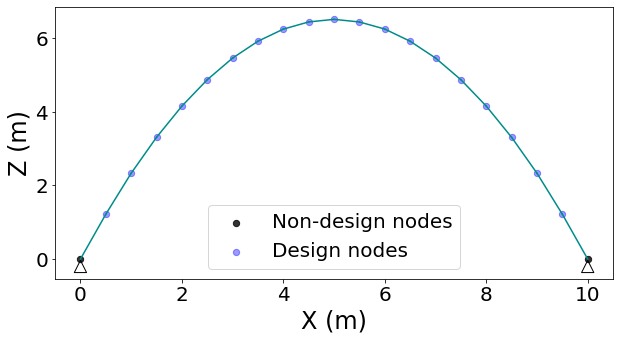

In [39]:
#Update the nodes
z_nodes[design_nodes] = x_opt
z_ele[:,0] = z_nodes[cnct[:,0]]
z_ele[:,1] = z_nodes[cnct[:,1]]

fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
ax.tick_params(labelsize=20)
#ax.set_ylim(-0.5,5)
ax.set_xlabel('X (m)',fontsize=24)
ax.set_ylabel('Z (m)',fontsize=24)
#Plot a basic wireframe.
for i in range(n_ele):
  ax.plot([x_ele[i,0],x_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='darkcyan')

plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes],color='black',alpha=0.8,label='Non-design nodes',s=40)
plt.scatter(x_nodes[non_design_nodes],z_nodes[non_design_nodes]-0.2, s=150, facecolors='none', edgecolors='black',marker='^')
ax.scatter(x_nodes[design_nodes],z_nodes[design_nodes],color='blue',alpha=0.4,label='Design nodes',s=40)

plt.legend(fontsize=20, loc='best')
plt.show()